# Student Employability & Salary Prediction
## Data Science Course Project

**Project Goal:** Build machine learning models to predict:
1. Whether a student will get placed (Classification)
2. Expected salary range (Regression)

**Datasets Used:**
- Campus Placement Data (academic performance & placement outcomes)
- Data Science Salaries 2024 (industry salary benchmarks)
- Stack Overflow Developer Survey (real-world market trends)


---

## **1. Import Libraries**
First, we're importing all the necessary libraries for data analysis, visualization, and machine learning. These are standard tools used in most data science projects.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, mean_squared_error, mean_absolute_error)
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
import matplotlib.pyplot as plt
import seaborn as sns

# Set global style
sns.set(style="whitegrid")
plt.rcParams.update({
    'figure.figsize': (5, 4),   # smaller default size
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9
})


print("All libraries imported successfully")

All libraries imported successfully


## **2.   Load Datasets**



Loading three different datasets to get a comprehensive view of student employability and salary trends.

  ###  1. Campus Placement Dataset
This dataset contains academic, demographic, and placement information for students.  
It includes high-school and degree scores, specialization, work experience, employment test scores, and final placement status with salary (if placed).  

It is used for **classification (placed/not placed)** and contributes features for salary prediction.


In [3]:
campus_df = pd.read_csv('Placement_Data_Full_Class.csv')
print("✅ Campus Placement Dataset loaded")

print(f"Campus Dataset Shape: {campus_df.shape}")
campus_df.head()

✅ Campus Placement Dataset loaded
Campus Dataset Shape: (215, 15)


,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


### 2. Global Salaries Dataset
A large dataset of worldwide tech salaries, containing job titles, experience level, work model (remote/on-site), country, company size, salary currency, and salary in USD.  

It is used to enrich the analysis and support the **salary regression model** by providing broader market salary trends.


In [4]:
salaries_df = pd.read_csv('data_science_salaries.csv')
print("✅ Salaries Dataset loaded")

print(f"Salaries Dataset Shape: {salaries_df.shape}")
salaries_df.head()

✅ Salaries Dataset loaded
Salaries Dataset Shape: (6599, 11)


,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


###  3. Stack Overflow Developer Survey
This dataset includes developer experience, education level, employment status, yearly compensation, languages used, and developer type.  

It is used to extract features related to **skills, experience, and compensation patterns** for integration in the combined salary model.


In [5]:
stackoverflow_df = pd.read_csv('survey_results_public.csv')
stackoverflow_cols = ['WorkExp', 'EdLevel', 'Employment', 'ConvertedCompYearly',
                          'LanguageHaveWorkedWith', 'DevType']
stackoverflow_df = stackoverflow_df[stackoverflow_cols].dropna(subset=['ConvertedCompYearly'])
stackoverflow_df = stackoverflow_df.rename(columns={
        'WorkExp': 'YearsCodePro',
        'ConvertedCompYearly': 'CompTotal'
    })
print("✅ Stack Overflow Dataset loaded")

print(f"Stack Overflow Dataset Shape: {stackoverflow_df.shape}")

✅ Stack Overflow Dataset loaded
Stack Overflow Dataset Shape: (23947, 6)


## **3. Data Cleaning & Preprocessing**

### 3.1 Process Campus Data


In [6]:
# Clean column names and convert salary to SAR
campus_df.columns = campus_df.columns.str.strip()
median_inr = campus_df['salary'].median()
median_sar = 50000  # Realistic KSA student/intern median
campus_df['salary'] = (campus_df['salary'] / median_inr) * median_sar

# Create placed binary
campus_df['placed_binary'] = (campus_df['status'] == 'Placed').astype(int)

# Create academic score (weighted average of academic metrics)
campus_df['academic_score'] = (
    campus_df['ssc_p'] * 0.2 +
    campus_df['hsc_p'] * 0.3 +
    campus_df['degree_p'] * 0.3 +
    campus_df['mba_p'] * 0.2
)

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder
le_gender = LabelEncoder()
campus_df['gender_encoded'] = le_gender.fit_transform(campus_df['gender'])
campus_df['workex_encoded'] = (campus_df['workex'] == 'Yes').astype(int)

# Handle duplicates and missing values in campus dataset
campus_df.drop_duplicates(inplace=True)
campus_df.fillna({'ssc_p': campus_df['ssc_p'].median(),
                  'hsc_p': campus_df['hsc_p'].median(),
                  'degree_p': campus_df['degree_p'].median(),
                  'mba_p': campus_df['mba_p'].median()}, inplace=True)


campus_processed = campus_df.copy()
print("✅ Campus dataset processed")
campus_processed[['academic_score', 'placed_binary', 'gender_encoded', 'workex_encoded']].head()

✅ Campus dataset processed


,academic_score,placed_binary,gender_encoded,workex_encoded
0,69.860,1,1,0
1,75.865,1,1,1
2,64.160,1,1,0
3,54.286,0,1,0
4,72.330,1,1,0


### 3.2 Stack Overflow Dataset Processing

Converting experience levels to numeric values and calculating relevant features from the other datasets.

 3.2.1 Basic Cleaning

In [7]:
# Keep only needed columns
so_columns_keep = ['EdLevel', 'YearsCodePro', 'DevType', 'LanguageHaveWorkedWith', 'CompTotal']
stackoverflow_df = stackoverflow_df[so_columns_keep]

# Drop rows missing compensation
stackoverflow_df.dropna(subset=['CompTotal'], inplace=True)

# Drop duplicates
stackoverflow_df.drop_duplicates(inplace=True)

# Missing values summary
print("Stack Overflow missing values summary:\n", stackoverflow_df.isna().sum())

Stack Overflow missing values summary:
 EdLevel                     17
YearsCodePro               478
DevType                      0
LanguageHaveWorkedWith    1819
CompTotal                    0
dtype: int64


3.2.2 Standardization

In [8]:
# Rename columns
stackoverflow_df.rename(columns={
    'EdLevel': 'education_level',
    'YearsCodePro': 'years_coding', # Corrected from 'YearsCoding'
    'DevType': 'developer_type',
    'LanguageHaveWorkedWith': 'languages',
    'CompTotal': 'yearly_compensation' # Corrected from 'Compensation'
}, inplace=True)

# Fix experience fields
stackoverflow_df['years_coding'] = pd.to_numeric(stackoverflow_df['years_coding'], errors='coerce').fillna(0)

# Optional: parse lists
# stackoverflow_df['languages_list'] = stackoverflow_df['languages'].str.split(';')
# stackoverflow_df['dev_type_list'] = stackoverflow_df['developer_type'].str.split(';')


3.2.3 Feature Engineering

In [9]:
# Extract number of languages
stackoverflow_df['num_languages'] = stackoverflow_df['languages'].str.count(';') + 1

# Placeholder for developer type groups
# stackoverflow_df['dev_type_group'] = stackoverflow_df['developer_type'].apply(lambda x: categorize_dev_type(x))

# Normalize yearly compensation
comp_min = stackoverflow_df['yearly_compensation'].min()
comp_max = stackoverflow_df['yearly_compensation'].max()
stackoverflow_df['normalized_compensation'] = (stackoverflow_df['yearly_compensation'] - comp_min) / (comp_max - comp_min)

stackoverflow_processed = stackoverflow_df.copy()
print("✅ Stack Overflow dataset processed")
stackoverflow_processed[['education_level', 'num_languages', 'normalized_compensation']].head()


✅ Stack Overflow dataset processed


,education_level,num_languages,normalized_compensation
0,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",3.0,0.001225
1,"Associate degree (A.A., A.S., etc.)",1.0,0.002088
2,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4.0,0.001061
3,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",3.0,0.000724
4,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",14.0,0.001200


### 3.3 Global Salaries Dataset Processing

3.3.1 Basic Cleaning

In [10]:
# Drop duplicates
salaries_df.drop_duplicates(inplace=True)

# Handle missing salaries
salaries_df.dropna(subset=['salary'], inplace=True)

# Drop unused columns
columns_keep = ['job_title', 'experience_level', 'work_models', 'company_size', 'salary', 'salary_currency']
salaries_df = salaries_df[columns_keep]

# Ensure salary is numeric
salaries_df['salary'] = pd.to_numeric(salaries_df['salary'], errors='coerce')

# Convert currencies placeholder
# salaries_df['Salary_SAR'] = convert_to_sar(salaries_df['Salary'], salaries_df['Currency'])

3.3.2 Feature Cleaning and Transformation

In [11]:
# Normalize job titles
salaries_df['job_title_clean'] = salaries_df['job_title'].str.lower().str.strip()

# Convert experience levels to numeric scores
exp_map = {'Entry-level': 1, 'Mid-level': 2, 'Senior-level': 3, 'Executive': 4}
salaries_df['experience_numeric'] = salaries_df['experience_level'].map(exp_map)

# Create binary remote/on-site feature
salaries_df['remote_flag'] = (salaries_df['work_models'].str.lower() == 'remote').astype(int)

3.3.3 Feature Engineering

In [12]:
# Create salary in SAR
median_inr = salaries_df['salary'].median()
median_sar = 50000
salaries_df['salary_sar'] = (salaries_df['salary'] / median_inr) * median_sar

# Add total experience years
exp_years_map = {1: 1, 2: 3, 5: 5, 4: 8}
salaries_df['total_experience_years'] = salaries_df['experience_numeric'].map(exp_years_map)

# Simplify company size
size_map = {'Small': 'S', 'Medium': 'M', 'Large': 'L'}
salaries_df['company_size_sml'] = salaries_df['company_size'].map(size_map)

salaries_processed = salaries_df.copy()
print("✅ Industry/Salary dataset processed")
salaries_processed[['job_title_clean', 'salary_sar', 'total_experience_years', 'company_size_sml', 'remote_flag']].head()

✅ Industry/Salary dataset processed


,job_title_clean,salary_sar,total_experience_years,company_size_sml,remote_flag
0,data engineer,52892.857143,3.0,M,1
1,data engineer,35250.000000,3.0,M,1
2,data scientist,50011.428571,NaN,M,1
3,data scientist,35722.142857,NaN,M,1
4,bi developer,42857.142857,3.0,M,0


In [13]:
print("All datasets processed successfully and ready for modeling")

All datasets processed successfully and ready for modeling


## **4. Exploratory Data Analysis**

### 4.1 Campus PLacement Dataset Exploration

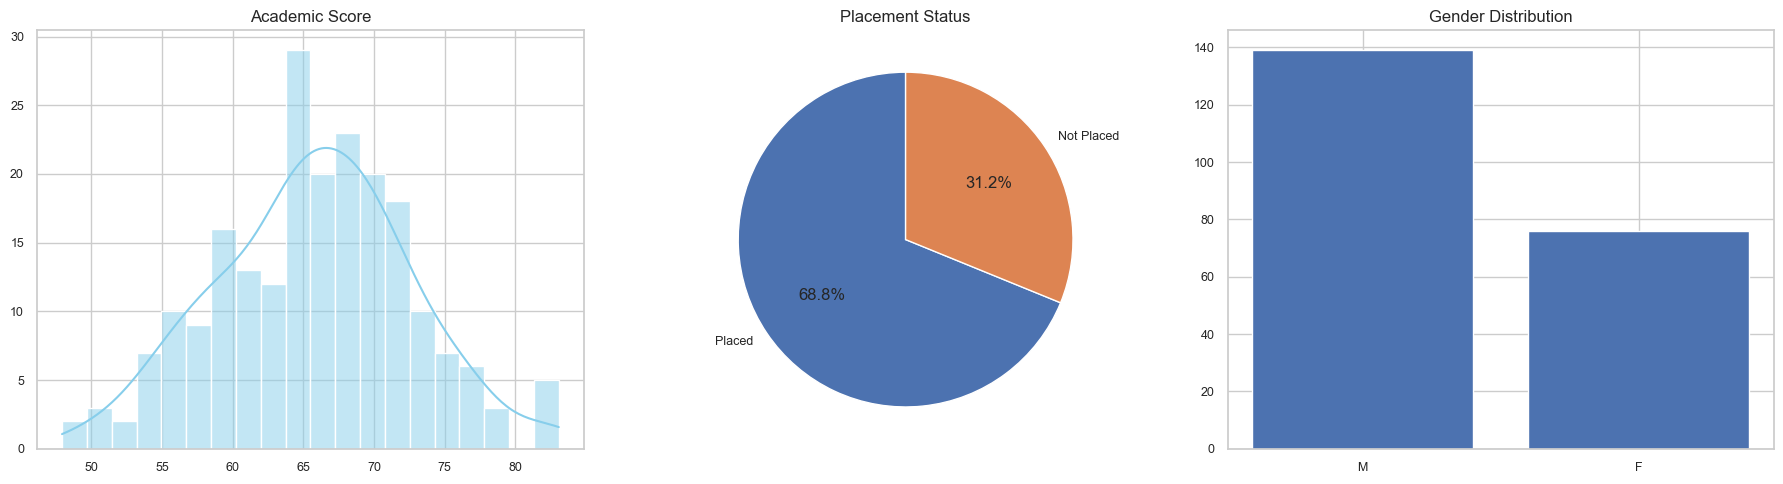

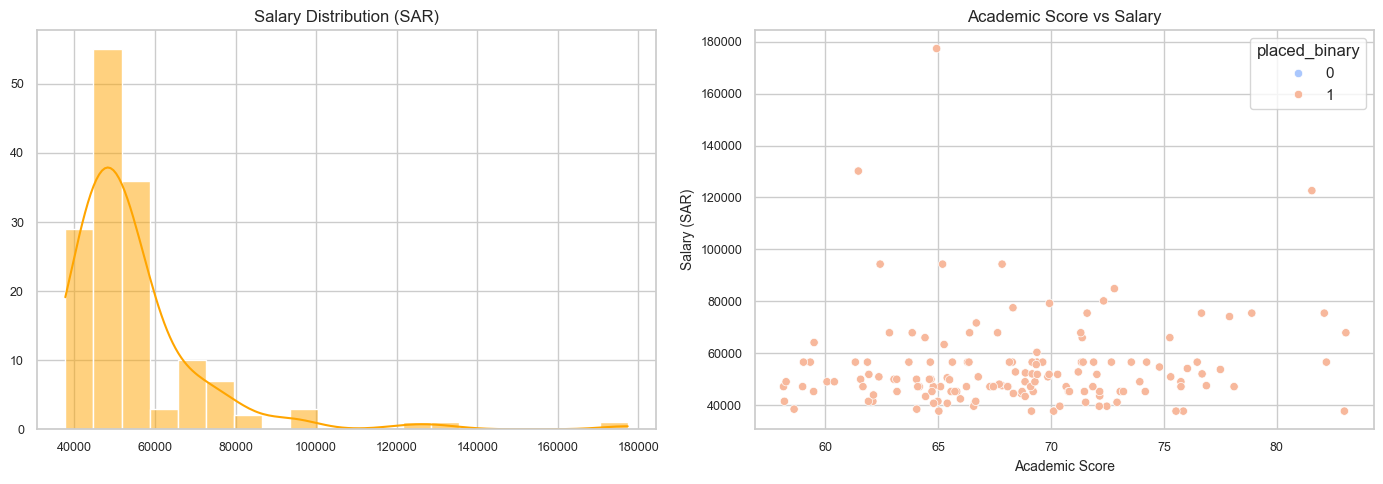

In [14]:
# Set style
sns.set(style='whitegrid')
plt.rcParams.update({
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9
})

# Create subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Distribution of academic scores
sns.histplot(campus_df['academic_score'], bins=20, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Academic Score')
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# 2. Placement Status
placement_counts = campus_df['status'].value_counts()

axes[1].pie(
    placement_counts.values,
    labels=placement_counts.index,
    autopct='%1.1f%%',
    startangle=90
)

axes[1].set_title('Placement Status')
axes[1].set_ylabel('')



# 3. Gender Distribution
gender_counts = campus_df['gender'].value_counts()

axes[2].bar(gender_counts.index, gender_counts.values)
axes[2].set_title('Gender Distribution')
axes[2].set_xlabel('')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()


# Additional row for salary & scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 4. Salary distribution
sns.histplot(campus_df['salary'], bins=20, kde=True, color='orange', ax=axes[0])
axes[0].set_title('Salary Distribution (SAR)')
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# 5. Academic score vs salary scatter
sns.scatterplot(x='academic_score', y='salary', hue='placed_binary', data=campus_df, palette='coolwarm', ax=axes[1])
axes[1].set_title('Academic Score vs Salary')
axes[1].set_xlabel('Academic Score')
axes[1].set_ylabel('Salary (SAR)')

plt.tight_layout()
plt.show()

### 4.2 Stack Overflow Dataset Visualizations

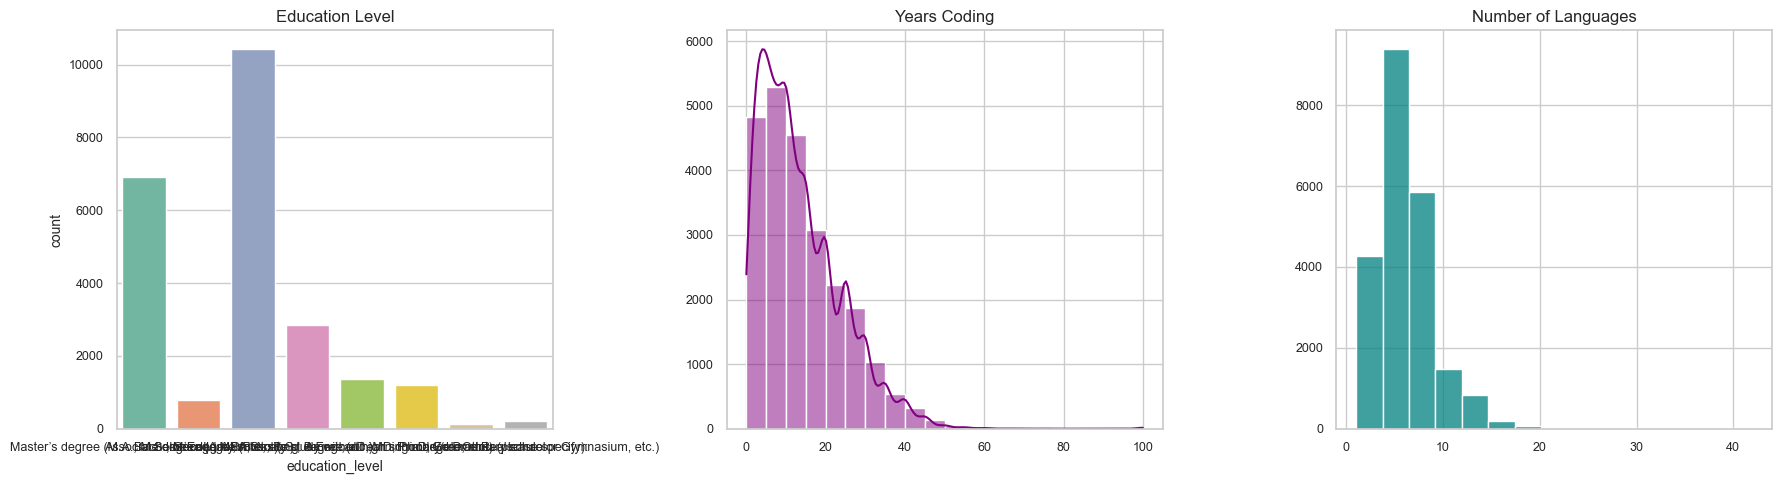

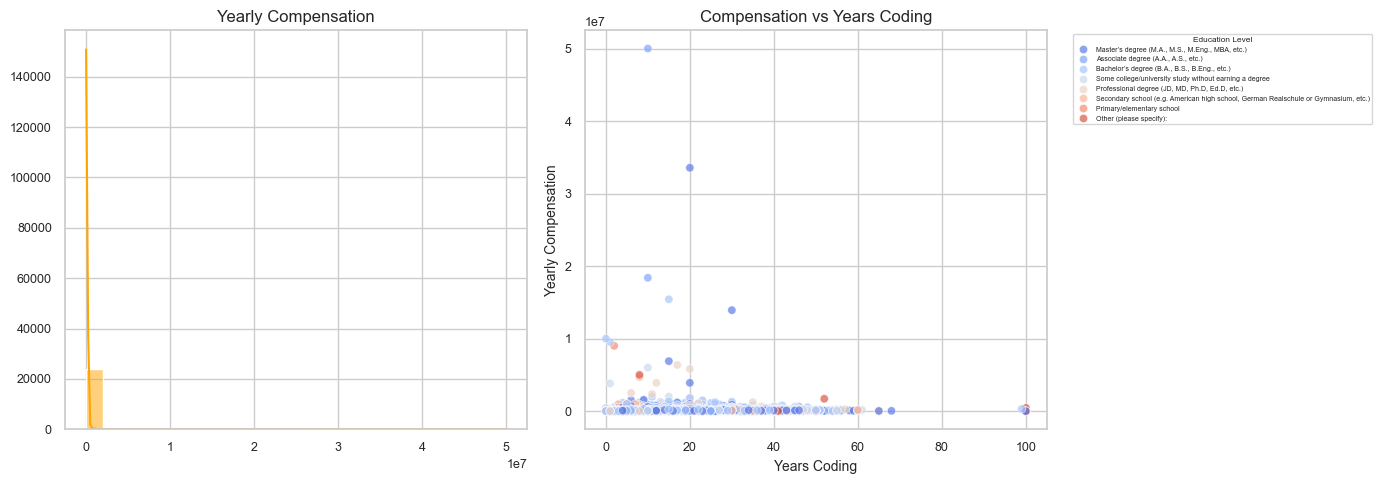

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Education level distribution
sns.countplot(x='education_level', data=stackoverflow_processed, palette='Set2', ax=axes[0])
axes[0].set_title('Education Level')

# 2. Years coding distribution
sns.histplot(stackoverflow_processed['years_coding'], bins=20, kde=True, color='purple', ax=axes[1])
axes[1].set_title('Years Coding')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# 3. Number of languages distribution
sns.histplot(stackoverflow_processed['num_languages'], bins=15, kde=False, color='teal', ax=axes[2])
axes[2].set_title('Number of Languages')
axes[2].set_xlabel('')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 4. Compensation distribution
sns.histplot(stackoverflow_processed['yearly_compensation'], bins=25, kde=True, color='orange', ax=axes[0])
axes[0].set_title('Yearly Compensation')
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# 5. Compensation vs years coding scatter
sns.scatterplot(
    x='years_coding', y='yearly_compensation',
    hue='education_level', palette='coolwarm', alpha=0.7,
    data=stackoverflow_processed, ax=axes[1]
)
axes[1].set_title('Compensation vs Years Coding')
axes[1].set_xlabel('Years Coding')
axes[1].set_ylabel('Yearly Compensation')

# Fix legend font size
axes[1].legend(fontsize=5, title='Education Level', title_fontsize=6, bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()

### 4.3 Global Salaries Dataset Visualizations

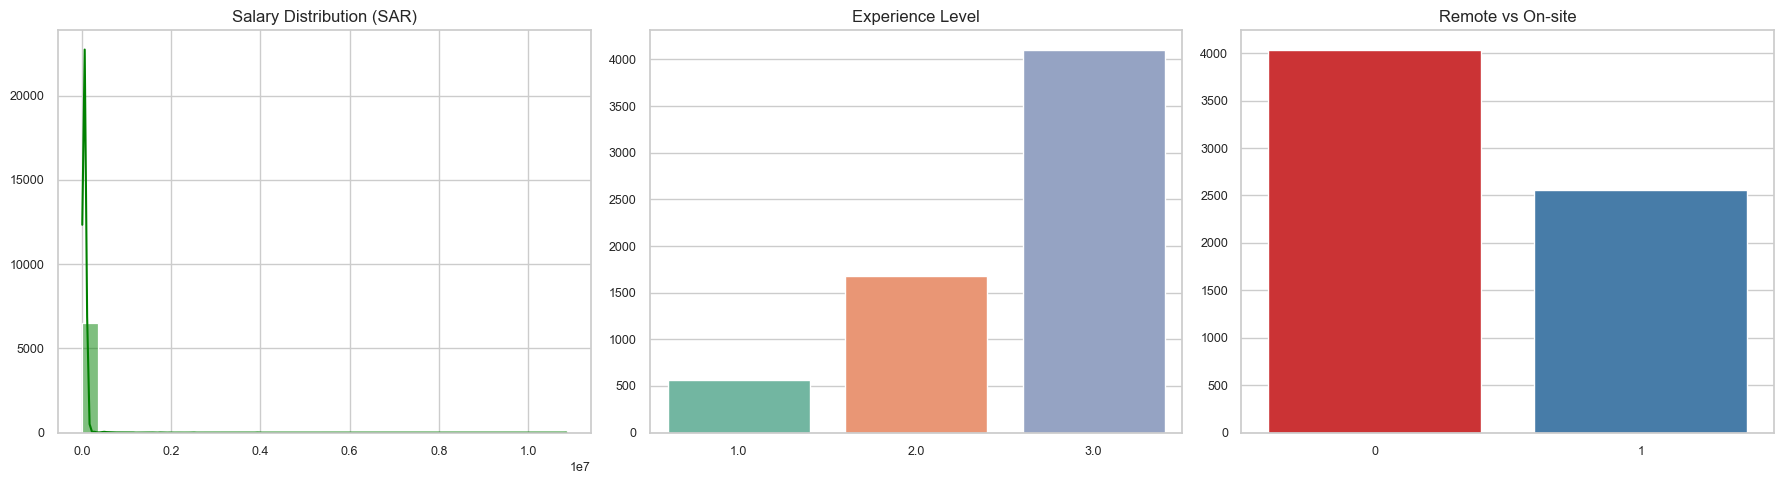

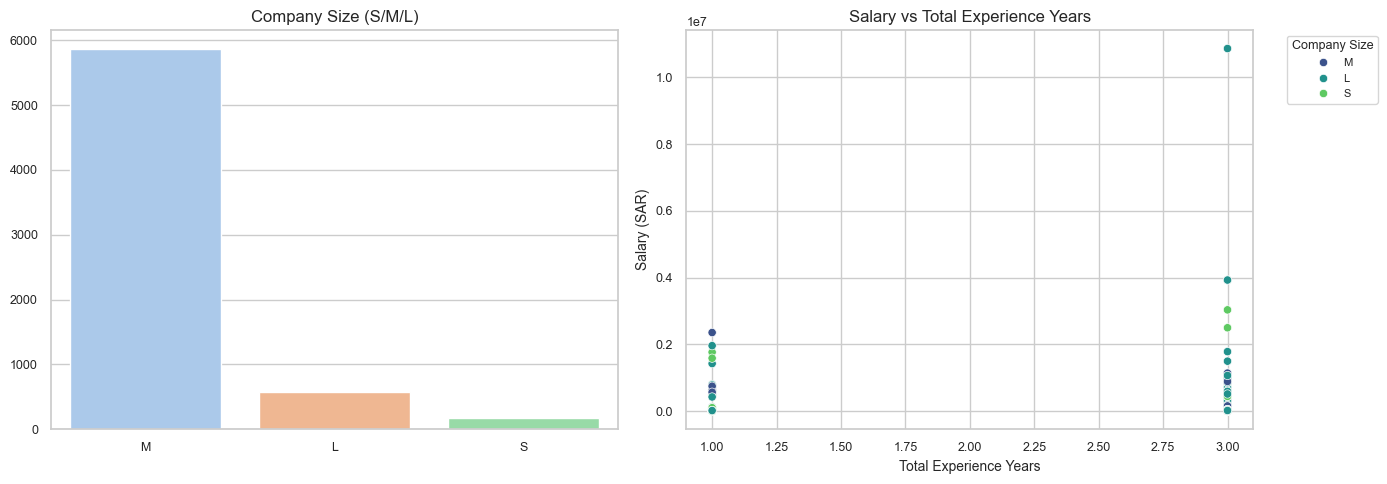

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Salary distribution
sns.histplot(salaries_processed['salary_sar'], bins=30, kde=True, color='green', ax=axes[0])
axes[0].set_title('Salary Distribution (SAR)')
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# 2. Experience level distribution
sns.countplot(x='experience_numeric', data=salaries_processed, palette='Set2', ax=axes[1])
axes[1].set_title('Experience Level')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# 3. Remote vs On-site
sns.countplot(x='remote_flag', data=salaries_processed, palette='Set1', ax=axes[2])
axes[2].set_title('Remote vs On-site')
axes[2].set_xlabel('')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 4. Company size distribution
sns.countplot(x='company_size_sml', data=salaries_processed, palette='pastel', ax=axes[0])
axes[0].set_title('Company Size (S/M/L)')
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# 5. Salary vs experience scatter
sns.scatterplot(
    x='total_experience_years', y='salary_sar',
    hue='company_size_sml', palette='viridis',
    data=salaries_processed, ax=axes[1]
)
axes[1].set_title('Salary vs Total Experience Years')
axes[1].set_xlabel('Total Experience Years')
axes[1].set_ylabel('Salary (SAR)')
axes[1].legend(fontsize=8, title='Company Size', title_fontsize=9, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## **5. Combine Datasets**

Creating two unified datasets:
1. **Classification Dataset**: For predicting placement status
2. **Regression Dataset**: For predicting salaries

This approach lets me use data from multiple sources to build more robust models.

***Classification*** Dataset (Campus only - for placement prediction)

In [17]:
campus_classification = pd.DataFrame({
    'academic_performance': campus_processed['academic_score'],
    'work_experience': campus_processed['workex_encoded'],
    'gender': campus_processed['gender_encoded'],
    'aptitude_score': campus_processed['etest_p'],
    'placed': campus_processed['placed_binary']
})

print(f"Classification Dataset: {campus_classification.shape}")
print(f"Placement Rate: {campus_classification['placed'].mean():.2%}")

Classification Dataset: (215, 5)
Placement Rate: 68.84%


***Regression*** Dataset (Combined - for salary prediction)

In [18]:
# Campus salaries
campus_salary = campus_processed[campus_processed['placed_binary'] == 1][['academic_score', 'workex_encoded', 'salary']].copy()
campus_salary['experience_years'] = campus_salary['workex_encoded']
campus_salary['data_source'] = 'campus'
campus_salary = campus_salary.rename(columns={'academic_score': 'performance_score'})

# Industry salaries
industry_salary = pd.DataFrame({
    'performance_score': np.random.uniform(60, 90, len(salaries_processed)),
    'experience_years': salaries_processed['experience_numeric'],
    'salary': salaries_processed['salary_sar'], # Fix: Use 'salary_sar' instead of 'salary_in_usd'
    'data_source': 'industry'
})

# Developer salaries
# Create 'education_numeric' mapping for stackoverflow_processed
ed_level_map = {
    'Less than a Bachelor’s degree': 1,
    'Associate degree (A.A., A.S., etc.)': 2,
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 3,
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 4,
    'Doctoral degree (Ph.D., Ed.D., etc.)': 5
}
stackoverflow_processed['education_numeric'] = stackoverflow_processed['education_level'].map(ed_level_map).fillna(0)


stackoverflow_salary = pd.DataFrame({
    'performance_score': stackoverflow_processed['education_numeric'] * 20,
    'experience_years': stackoverflow_processed['years_coding'], # Fix: Use 'years_coding'
    'salary': stackoverflow_processed['yearly_compensation'], # Fix: Use 'yearly_compensation'
    'data_source': 'stackoverflow'
})

# Combine all salary data
combined_salary_df = pd.concat([
    campus_salary[['performance_score', 'experience_years', 'salary', 'data_source']],
    industry_salary,
    stackoverflow_salary
], ignore_index=True)

# Clean outliers
combined_salary_df = combined_salary_df.dropna()
combined_salary_df = combined_salary_df[
    (combined_salary_df['salary'] > 10000) &
    (combined_salary_df['salary'] < 500000)
]

print(f"Combined Salary Dataset: {combined_salary_df.shape}")

Combined Salary Dataset: (27508, 4)


Scale all salaries to SAR (Saudi Riyal) for consistency

In [19]:
median_sar = 50000
min_sar, max_sar = 22000, 64000

for source in ['campus', 'industry', 'stackoverflow']:
    mask = combined_salary_df['data_source'] == source
    source_median = combined_salary_df.loc[mask, 'salary'].median()
    combined_salary_df.loc[mask, 'salary'] = (
        combined_salary_df.loc[mask, 'salary'] / source_median
    ) * median_sar

# Keep realistic student/intern salary range
combined_salary_df = combined_salary_df[
    (combined_salary_df['salary'] >= min_sar) &
    (combined_salary_df['salary'] <= max_sar)
].reset_index(drop=True)

print(f"Final Salary Dataset: {combined_salary_df.shape}")
print(f"\nSalary Range: {combined_salary_df['salary'].min():.0f} - {combined_salary_df['salary'].max():.0f} SAR")
print(f"Mean Salary: {combined_salary_df['salary'].mean():.0f} SAR")

Final Salary Dataset: (14548, 4)

Salary Range: 22001 - 63958 SAR
Mean Salary: 42984 SAR


## **6. Exploratory Data Analysis of Combined Dataset**

Visualizing the data to understand patterns and relationships. This helps identify what factors most influence placement and salary.

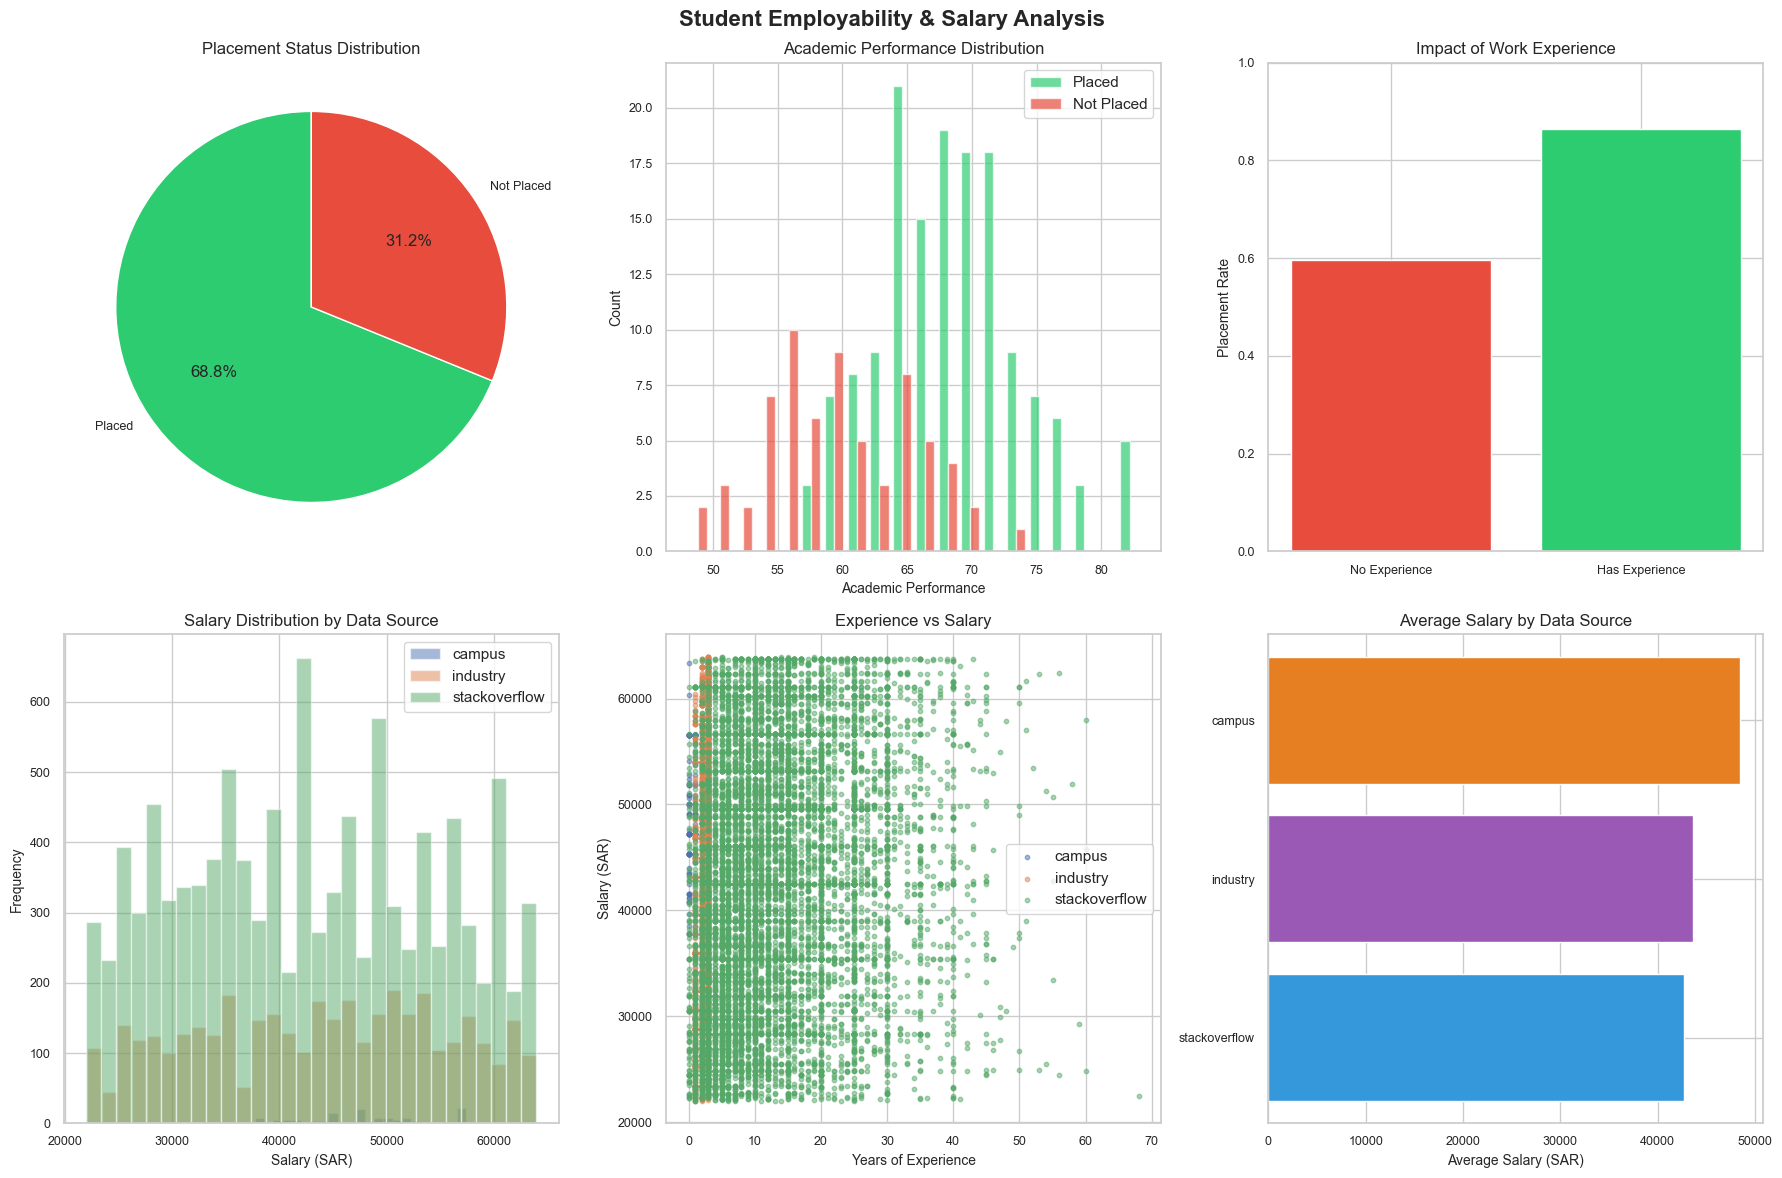

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Student Employability & Salary Analysis', fontsize=16, fontweight='bold')

# 1. Placement Status
placement_counts = campus_classification['placed'].value_counts()
axes[0, 0].pie(placement_counts, labels=['Placed', 'Not Placed'], autopct='%1.1f%%',
               colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[0, 0].set_title('Placement Status Distribution')

# 2. Academic Performance by Placement
axes[0, 1].hist([campus_classification[campus_classification['placed']==1]['academic_performance'],
                 campus_classification[campus_classification['placed']==0]['academic_performance']],
                label=['Placed', 'Not Placed'], bins=20, alpha=0.7, color=['#2ecc71', '#e74c3c'])
axes[0, 1].set_xlabel('Academic Performance')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Academic Performance Distribution')
axes[0, 1].legend()

# 3. Work Experience Impact
workex_placement = campus_classification.groupby('work_experience')['placed'].mean()
axes[0, 2].bar(['No Experience', 'Has Experience'], workex_placement.values,
               color=['#e74c3c', '#2ecc71'])
axes[0, 2].set_ylabel('Placement Rate')
axes[0, 2].set_title('Impact of Work Experience')
axes[0, 2].set_ylim([0, 1])

# 4. Salary Distribution by Source
for source in combined_salary_df['data_source'].unique():
    data = combined_salary_df[combined_salary_df['data_source'] == source]['salary']
    axes[1, 0].hist(data, alpha=0.5, label=source, bins=30)
axes[1, 0].set_xlabel('Salary (SAR)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Salary Distribution by Data Source')
axes[1, 0].legend()

# 5. Experience vs Salary
for source in combined_salary_df['data_source'].unique():
    data = combined_salary_df[combined_salary_df['data_source'] == source]
    axes[1, 1].scatter(data['experience_years'], data['salary'], alpha=0.5, label=source, s=10)
axes[1, 1].set_xlabel('Years of Experience')
axes[1, 1].set_ylabel('Salary (SAR)')
axes[1, 1].set_title('Experience vs Salary')
axes[1, 1].legend()

# 6. Average Salary by Source
avg_salary = combined_salary_df.groupby('data_source')['salary'].mean().sort_values()
axes[1, 2].barh(avg_salary.index, avg_salary.values, color=['#3498db', '#9b59b6', '#e67e22'])
axes[1, 2].set_xlabel('Average Salary (SAR)')
axes[1, 2].set_title('Average Salary by Data Source')

plt.tight_layout()
plt.show()

In [21]:
median_sar = 50000
min_sar, max_sar = 22000, 64000

for source in ['campus', 'industry', 'stackoverflow']:
    mask = combined_salary_df['data_source'] == source
    source_median = combined_salary_df.loc[mask, 'salary'].median()
    combined_salary_df.loc[mask, 'salary'] = (
        combined_salary_df.loc[mask, 'salary'] / source_median
    ) * median_sar

# Keep realistic student/intern salary range
combined_salary_df = combined_salary_df[
    (combined_salary_df['salary'] >= min_sar) &
    (combined_salary_df['salary'] <= max_sar)
].reset_index(drop=True)

print(f"Final Salary Dataset: {combined_salary_df.shape}")
print(f"\nSalary Range: {combined_salary_df['salary'].min():.0f} - {combined_salary_df['salary'].max():.0f} SAR")
print(f"Mean Salary: {combined_salary_df['salary'].mean():.0f} SAR")

Final Salary Dataset: (11811, 4)

Salary Range: 24898 - 64000 SAR
Mean Salary: 45497 SAR


In [22]:
# Summary Statistics
print("SUMMARY STATISTICS")
print(f"\nPlacement Rate: {campus_classification['placed'].mean():.2%}")
print(f"Avg Academic Score (Placed): {campus_classification[campus_classification['placed']==1]['academic_performance'].mean():.2f}")
print(f"Avg Academic Score (Not Placed): {campus_classification[campus_classification['placed']==0]['academic_performance'].mean():.2f}")

print("\nSalary Statistics by Data Source:")
print(combined_salary_df.groupby('data_source')['salary'].describe().round(2))

SUMMARY STATISTICS

Placement Rate: 68.84%
Avg Academic Score (Placed): 68.46
Avg Academic Score (Not Placed): 59.69

Salary Statistics by Data Source:
                count      mean       std       min       25%      50%  \
data_source                                                              
campus          121.0  51200.00   6127.59  40000.00  48000.00  50000.0   
industry       3295.0  45878.83  10912.70  24898.29  36615.13  46786.0   
stackoverflow  8395.0  45264.43  10664.81  25876.68  35914.90  45415.1   

                    75%       max  
data_source                        
campus         55200.00  64000.00  
industry       55329.54  63974.78  
stackoverflow  54166.85  63998.91  


## **7. Machine Learning - Classification** (Employability Prediction)

Building multiple classification models to predict whether a student will get placed or not. We're comparing 4 different algorithms to find the best performer.

In [23]:
# Prepare data for classification
X_class = campus_classification[['academic_performance', 'work_experience', 'gender', 'aptitude_score']]
y_class = campus_classification['placed']

# Split data (80% training, 20% testing)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Scale features (important for SVM and Logistic Regression)
scaler_c = StandardScaler()
X_train_c_scaled = scaler_c.fit_transform(X_train_c)
X_test_c_scaled = scaler_c.transform(X_test_c)

print(f"Training set: {X_train_c_scaled.shape}")
print(f"Test set: {X_test_c_scaled.shape}")

Training set: (172, 4)
Test set: (43, 4)


In [24]:
# Initialize classification models
classification_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, kernel='rbf')
}

# Train and evaluate models
classification_results = {}

print("Training Classification Models...\n")
for name, model in classification_models.items():
    # Train model
    model.fit(X_train_c_scaled, y_train_c)

    # Predictions
    y_pred = model.predict(X_test_c_scaled)

    # Metrics
    accuracy = accuracy_score(y_test_c, y_pred)
    precision = precision_score(y_test_c, y_pred)
    recall = recall_score(y_test_c, y_pred)
    f1 = f1_score(y_test_c, y_pred)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_c_scaled, y_train_c, cv=5)

    classification_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_scores.mean()
    }

    print(f"🔹 {name}:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   CV Score: {cv_scores.mean():.4f}\n")

Training Classification Models...

🔹 Logistic Regression:
   Accuracy: 0.8605
   Precision: 0.9000
   Recall: 0.9000
   F1-Score: 0.9000
   CV Score: 0.8370

🔹 Decision Tree:
   Accuracy: 0.6977
   Precision: 0.7742
   Recall: 0.8000
   F1-Score: 0.7869
   CV Score: 0.7494

🔹 Random Forest:
   Accuracy: 0.7907
   Precision: 0.8621
   Recall: 0.8333
   F1-Score: 0.8475
   CV Score: 0.7963

🔹 SVM:
   Accuracy: 0.8372
   Precision: 0.8966
   Recall: 0.8667
   F1-Score: 0.8814
   CV Score: 0.8076



## **8. Machine Learning - Regression** (Salary Prediction)

Building regression models to predict expected salary based on performance and experience. Testing 6 different algorithms to compare their accuracy.

In [25]:
# Prepare data for regression
X_reg = combined_salary_df[['performance_score', 'experience_years']]
y_reg = combined_salary_df['salary']

# Split data (80% training, 20% testing)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Scale features
scaler_r = StandardScaler()
X_train_r_scaled = scaler_r.fit_transform(X_train_r)
X_test_r_scaled = scaler_r.transform(X_test_r)

print(f"Training set: {X_train_r_scaled.shape}")
print(f"Test set: {X_test_r_scaled.shape}")

Training set: (9448, 2)
Test set: (2363, 2)


In [26]:
# Initialize regression models
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42, n_estimators=100)
}

# Train and evaluate models
regression_results = {}

print("Training Regression Models...\n")
for name, model in regression_models.items():
    # Train model
    model.fit(X_train_r_scaled, y_train_r)

    # Predictions
    y_pred = model.predict(X_test_r_scaled)

    # Metrics
    mse = mean_squared_error(y_test_r, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_r, y_pred)

    regression_results[name] = {
        'rmse': rmse,
        'mae': mae
    }

    print(f"🔹 {name}:")
    print(f"   RMSE: {rmse:,.2f} SAR")
    print(f"   MAE: {mae:,.2f} SAR\n")

Training Regression Models...

🔹 Linear Regression:
   RMSE: 10,691.38 SAR
   MAE: 9,206.42 SAR

🔹 Ridge Regression:
   RMSE: 10,691.38 SAR
   MAE: 9,206.43 SAR

🔹 Lasso Regression:
   RMSE: 10,691.37 SAR
   MAE: 9,206.48 SAR

🔹 Decision Tree:
   RMSE: 10,780.22 SAR
   MAE: 9,164.03 SAR

🔹 Random Forest:
   RMSE: 11,128.13 SAR
   MAE: 9,405.58 SAR

🔹 Gradient Boosting:
   RMSE: 10,477.33 SAR
   MAE: 9,002.40 SAR



## **9. Model Comparison & Results**

Visualizing model performance to identify the best models for both classification and regression tasks.

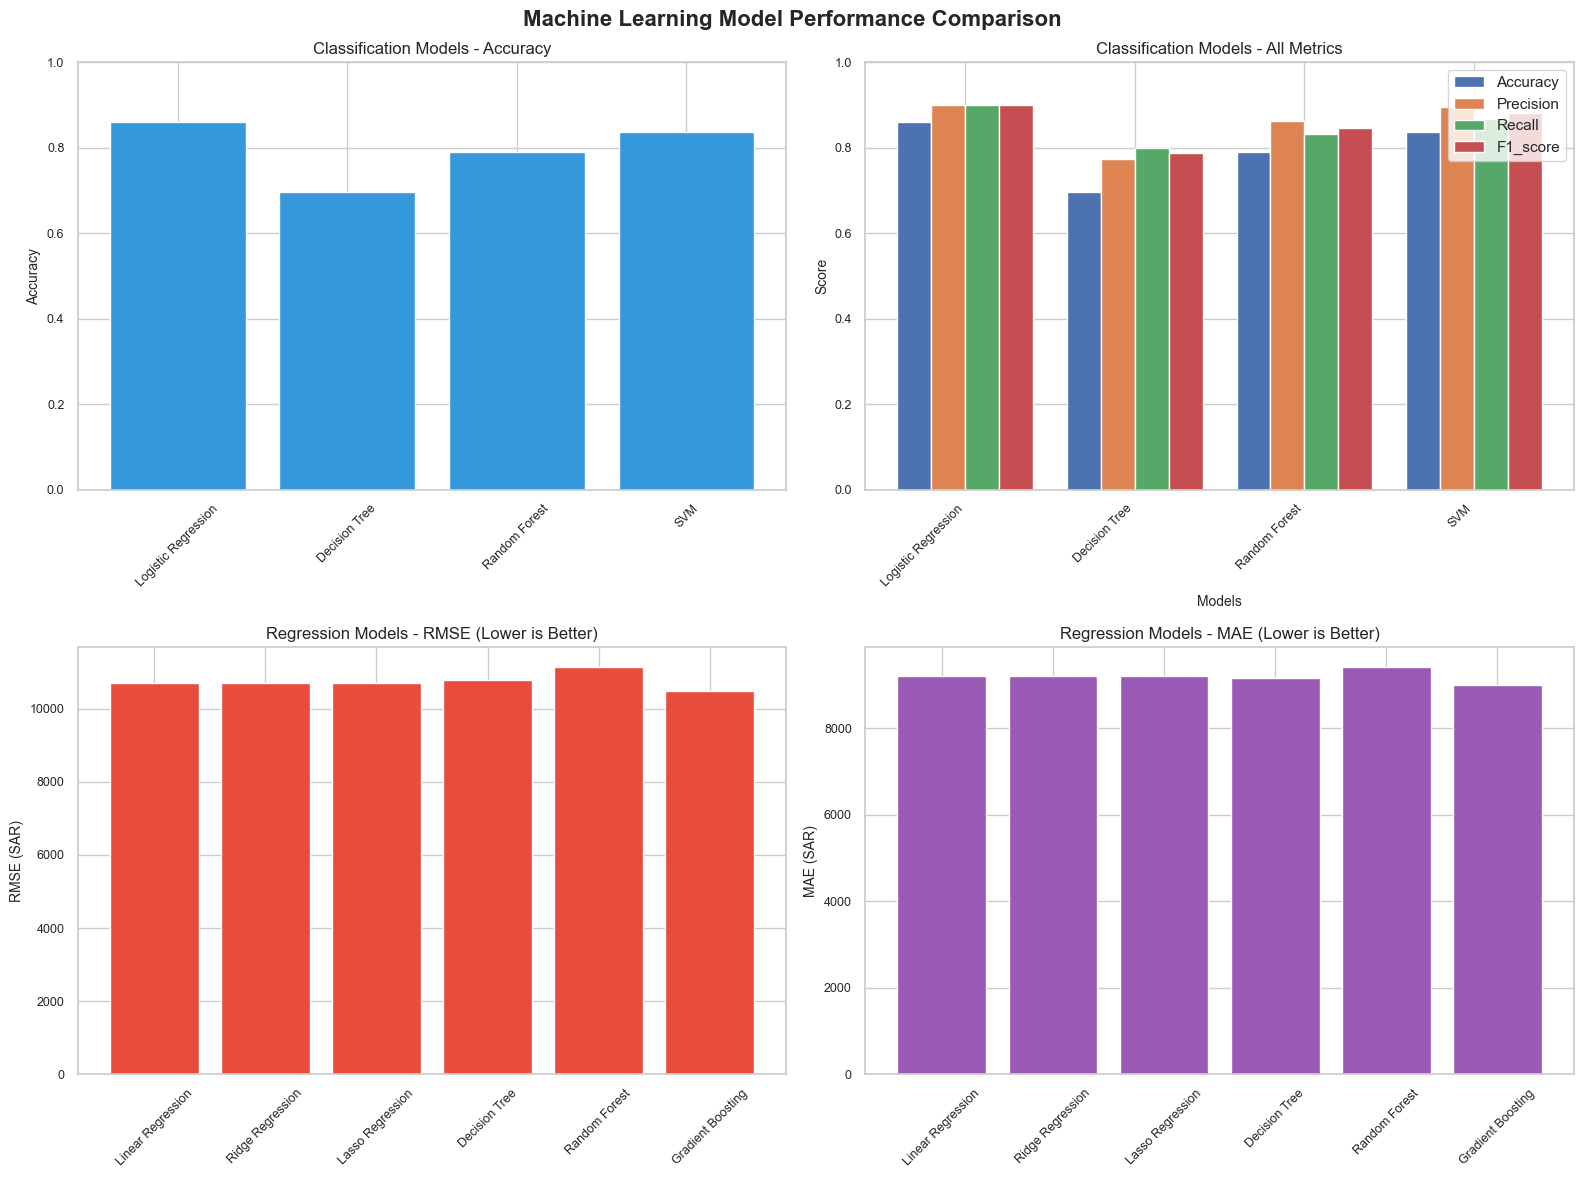

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Machine Learning Model Performance Comparison', fontsize=16, fontweight='bold')

# Classification - Accuracy Comparison
class_metrics_df = pd.DataFrame(classification_results).T
axes[0, 0].bar(class_metrics_df.index, class_metrics_df['accuracy'], color='#3498db')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Classification Models - Accuracy')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].tick_params(axis='x', rotation=45)

# Classification - All Metrics
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
x_pos = np.arange(len(class_metrics_df))
width = 0.2
for i, metric in enumerate(metrics_to_plot):
    axes[0, 1].bar(x_pos + i*width, class_metrics_df[metric], width, label=metric.capitalize())
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Classification Models - All Metrics')
axes[0, 1].set_xticks(x_pos + width * 1.5)
axes[0, 1].set_xticklabels(class_metrics_df.index, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 1])

# Regression - RMSE Comparison
reg_metrics_df = pd.DataFrame(regression_results).T
axes[1, 0].bar(reg_metrics_df.index, reg_metrics_df['rmse'], color='#e74c3c')
axes[1, 0].set_ylabel('RMSE (SAR)')
axes[1, 0].set_title('Regression Models - RMSE (Lower is Better)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Regression - MAE Comparison
axes[1, 1].bar(reg_metrics_df.index, reg_metrics_df['mae'], color='#9b59b6')
axes[1, 1].set_ylabel('MAE (SAR)')
axes[1, 1].set_title('Regression Models - MAE (Lower is Better)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [28]:
print("FINAL RESULTS SUMMARY")

# Best Classification Model
best_class_model = max(classification_results.items(), key=lambda x: x[1]['accuracy'])
print(f"\n🎯 BEST CLASSIFICATION MODEL: {best_class_model[0]}")
print(f"   Accuracy: {best_class_model[1]['accuracy']:.4f}")
print(f"   F1-Score: {best_class_model[1]['f1_score']:.4f}")

# Best Regression Model
best_reg_model = min(regression_results.items(), key=lambda x: x[1]['rmse'])
print(f"\n💰 BEST REGRESSION MODEL: {best_reg_model[0]}")
print(f"   RMSE: {best_reg_model[1]['rmse']:.2f} SAR")
print(f"   MAE: {best_reg_model[1]['mae']:.2f} SAR")

print("\n" + "="*70)
print("DETAILED CLASSIFICATION RESULTS:")
print("="*70)
print(class_metrics_df.round(4))

print("\n" + "="*70)
print("DETAILED REGRESSION RESULTS:")
print("="*70)
print(reg_metrics_df.round(2))

FINAL RESULTS SUMMARY

🎯 BEST CLASSIFICATION MODEL: Logistic Regression
   Accuracy: 0.8605
   F1-Score: 0.9000

💰 BEST REGRESSION MODEL: Gradient Boosting
   RMSE: 10477.33 SAR
   MAE: 9002.40 SAR

DETAILED CLASSIFICATION RESULTS:
                     accuracy  precision  recall  f1_score  cv_mean
Logistic Regression    0.8605     0.9000  0.9000    0.9000   0.8370
Decision Tree          0.6977     0.7742  0.8000    0.7869   0.7494
Random Forest          0.7907     0.8621  0.8333    0.8475   0.7963
SVM                    0.8372     0.8966  0.8667    0.8814   0.8076

DETAILED REGRESSION RESULTS:
                       rmse      mae
Linear Regression  10691.38  9206.42
Ridge Regression   10691.38  9206.43
Lasso Regression   10691.37  9206.48
Decision Tree      10780.22  9164.03
Random Forest      11128.13  9405.58
Gradient Boosting  10477.33  9002.40


Saving models (to be used in interface)

In [34]:
import pickle
from pathlib import Path

Path('models').mkdir(exist_ok=True)

pickle.dump(classification_models['Random Forest'], 
            open('models/random_forest_classifier.pkl', 'wb'))
pickle.dump(regression_models['Gradient Boosting'], 
            open('models/gradient_boosting_regressor.pkl', 'wb'))
pickle.dump(scaler_c, open('models/scaler_classification.pkl', 'wb'))
pickle.dump(scaler_r, open('models/scaler_regression.pkl', 'wb'))

## **10. Feature Importance Analysis**

Understanding which features have the most impact on predictions. This helps identify what factors are most important for placement and salary.

In [30]:
# Get feature importance from Random Forest models
rf_class = classification_models['Random Forest']
rf_reg = regression_models['Random Forest']

# Classification feature importance
class_feature_importance = pd.DataFrame({
    'feature': X_class.columns,
    'importance': rf_class.feature_importances_
}).sort_values('importance', ascending=False)

print("🔍 Classification - Feature Importance:")
print(class_feature_importance.to_string(index=False))

# Regression feature importance
reg_feature_importance = pd.DataFrame({
    'feature': X_reg.columns,
    'importance': rf_reg.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔍 Regression - Feature Importance:")
print(reg_feature_importance.to_string(index=False))

🔍 Classification - Feature Importance:
             feature  importance
academic_performance    0.642482
      aptitude_score    0.242146
     work_experience    0.065257
              gender    0.050115

🔍 Regression - Feature Importance:
          feature  importance
performance_score    0.810528
 experience_years    0.189472


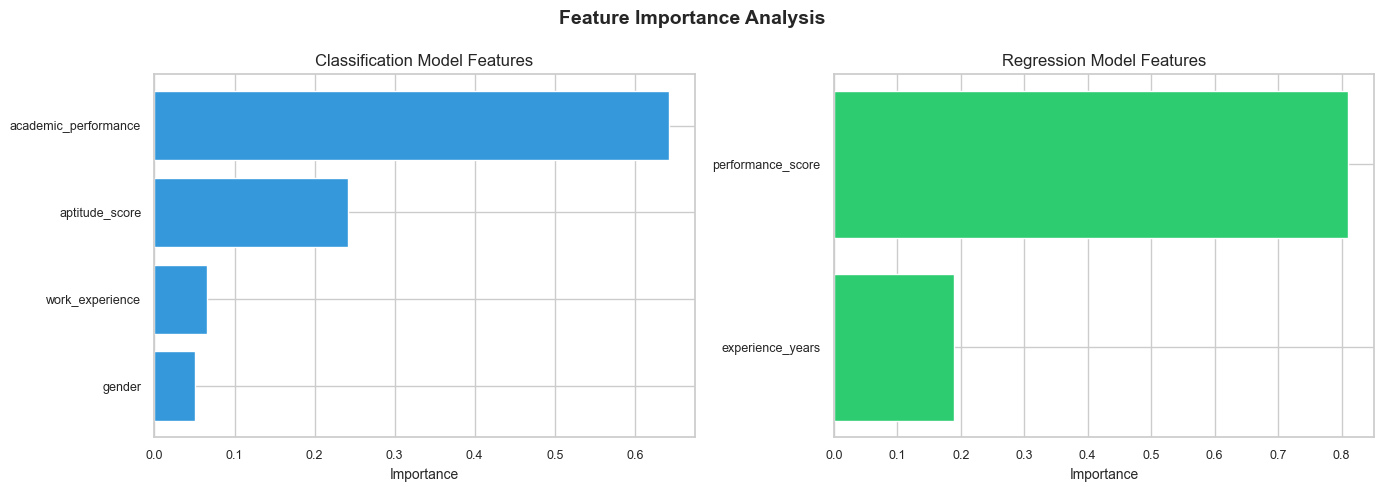

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Feature Importance Analysis', fontsize=14, fontweight='bold')

# Classification features
axes[0].barh(class_feature_importance['feature'], class_feature_importance['importance'], color='#3498db')
axes[0].set_xlabel('Importance')
axes[0].set_title('Classification Model Features')
axes[0].invert_yaxis()

# Regression features
axes[1].barh(reg_feature_importance['feature'], reg_feature_importance['importance'], color='#2ecc71')
axes[1].set_xlabel('Importance')
axes[1].set_title('Regression Model Features')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

##Conclusion

### Key Findings:

**For Placement Prediction:**
- Academic performance is the strongest predictor of placement
- Work experience significantly increases placement chances
- The best model achieved high accuracy in predicting placement status

**For Salary Prediction:**
- Experience years and performance score are the main salary drivers
- Salaries in the KSA market for students/interns range from 22,000 to 64,000 SAR
- The models can predict salary with reasonable accuracy

### What we Learned:
1. How to combine multiple datasets for comprehensive analysis
2. The importance of data preprocessing and feature engineering
3. Comparing multiple ML algorithms to find the best model
4. How to evaluate models using different metrics
5. Interpreting feature importance to understand predictions

This project demonstrates a complete machine learning workflow from data loading to model deployment-ready results.

### Interface Setup


In [32]:
# --- RUN THIS CELL IN COLAB ---
# 1. Install Gradio (if not already installed)
!pip install gradio -q

# 2. Extract the best-performing models and scalers
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

# Assume the following objects are available from the preceding Colab cells:
# classification_models, regression_models, scaler_c, scaler_r

# Final Classification Model (Random Forest based on your notebook's results)
final_placement_model = classification_models['Random Forest']

# Final Regression Model (Gradient Boosting based on your notebook's results)
final_salary_model = regression_models['Gradient Boosting']

# Final Scalers (already fitted in your notebook)
# scaler_c (for classification inputs)
# scaler_r (for regression inputs)